In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('cleaned_data.csv')
df.head()

,DATE,INF_A,INF_B
0,1996-12-29,0.0,0.0
1,1997-02-23,0.0,0.0
2,1997-03-02,0.0,0.0
3,1997-03-09,0.0,0.0
4,1997-03-16,0.0,0.0


In [4]:
df.shape

(1116, 3)

### Convert DATE column to datetime and Set the DATE as the index

In [5]:
from datetime import datetime

# Convert DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Set the DATE as the index
df.set_index('DATE', inplace=True)


In [6]:
df.head()

,INF_A,INF_B
DATE,,
1996-12-29,0.0,0.0
1997-02-23,0.0,0.0
1997-03-02,0.0,0.0
1997-03-09,0.0,0.0
1997-03-16,0.0,0.0


### Define training and testing split date and Split data into training and testing

In [7]:
train_end_date = pd.to_datetime("2023-12-31")
train = df[df.index <= train_end_date]
test = df[df.index > train_end_date]

# Select the forward-filled columns for modeling
train_data = train[['INF_A', 'INF_B']]
test_data = test[['INF_A', 'INF_B']]

train_data.shape, test_data.shape


((1088, 2), (28, 2))

In [8]:
train_data.head()

,INF_A,INF_B
DATE,,
1996-12-29,0.0,0.0
1997-02-23,0.0,0.0
1997-03-02,0.0,0.0
1997-03-09,0.0,0.0
1997-03-16,0.0,0.0


### Scale the data and Scale each series separately using MinMaxScaler

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Define window size
window_size = 4

scalers = {
    'INF_A': MinMaxScaler(),
    'INF_B': MinMaxScaler()
}

train_scaled = {}
test_scaled = {}

for key, scaler in scalers.items():
    train_scaled[key] = scaler.fit_transform(train_data[[f"{key}"]])
    test_scaled[key] = scaler.transform(test_data[[f"{key}"]])

# Function to create sequences
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)



### Prepare sequence for INF_A and INF_B

In [10]:
# Prepare sequences for INF_A
X_train_A, y_train_A = create_sequences(train_scaled['INF_A'], window_size)
X_test_A, y_test_A = create_sequences(test_scaled['INF_A'], window_size)

# Prepare sequences for INF_B
X_train_B, y_train_B = create_sequences(train_scaled['INF_B'], window_size)
X_test_B, y_test_B = create_sequences(test_scaled['INF_B'], window_size)

# Show shapes
X_train_A.shape, y_train_A.shape, X_test_A.shape, y_test_A.shape

((1084, 4, 1), (1084, 1), (24, 4, 1), (24, 1))

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
# Function to create and train LSTM model
def train_lstm(X_train, y_train, X_val, y_val, epochs=50, batch_size=16):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs,
              batch_size=batch_size, verbose=0, callbacks=[early_stop])
    return model



### Train LSTM for INF_A and INF_B

In [13]:
model_A = train_lstm(X_train_A, y_train_A, X_test_A, y_test_A)
model_B = train_lstm(X_train_B, y_train_B, X_test_B, y_test_B)

# Predict and inverse scale
pred_A = scalers['INF_A'].inverse_transform(model_A.predict(X_test_A))
true_A = scalers['INF_A'].inverse_transform(y_test_A)

pred_B = scalers['INF_B'].inverse_transform(model_B.predict(X_test_B))
true_B = scalers['INF_B'].inverse_transform(y_test_B)

pred_A[:5], true_A[:5]  # Show sample predictions for INF_A




1/1 [==============================] - 0s 90ms/step


(array([[38.745205],
        [29.88128 ],
        [38.004734],
        [53.524704],
        [38.83674 ]], dtype=float32),
 array([[14.],
        [25.],
        [41.],
        [18.],
        [50.]]))

In [14]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [15]:
rmse = root_mean_squared_error(pred_A, true_A)
mae = mean_absolute_error(pred_A, true_A)
mape = mean_absolute_percentage_error(pred_A, true_A)

### Performance metrics for INF_A:

In [16]:
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

RMSE: 20.834455521998233
MAE: 17.822278022766113
MAPE: 0.3943441882728453


In [17]:
rmse = root_mean_squared_error(pred_B, true_B)
mae = mean_absolute_error(pred_B, true_B)
mape = mean_absolute_percentage_error(pred_B,true_B)

### Performance metrics for INF_B:

In [18]:
print('RMSE:', rmse)
print('MAE:', mae)
print('MAPE:', mape)

RMSE: 3.405047993760713
MAE: 2.4588038126627603
MAPE: 0.5588095110153875


In [19]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(true_values, predicted_values, title):
    plt.figure(figsize=(10, 5))
    plt.plot(true_values, label='Actual')
    plt.plot(predicted_values, label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Influenza Cases')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



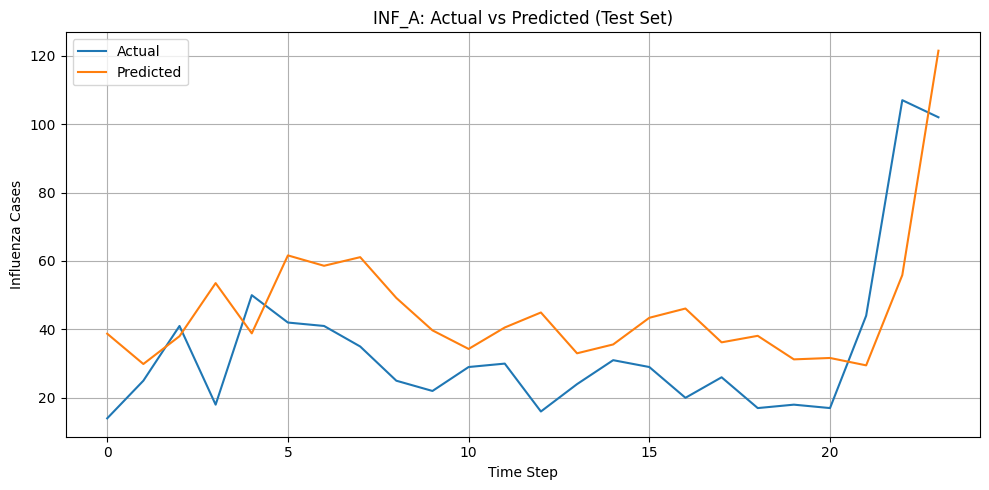

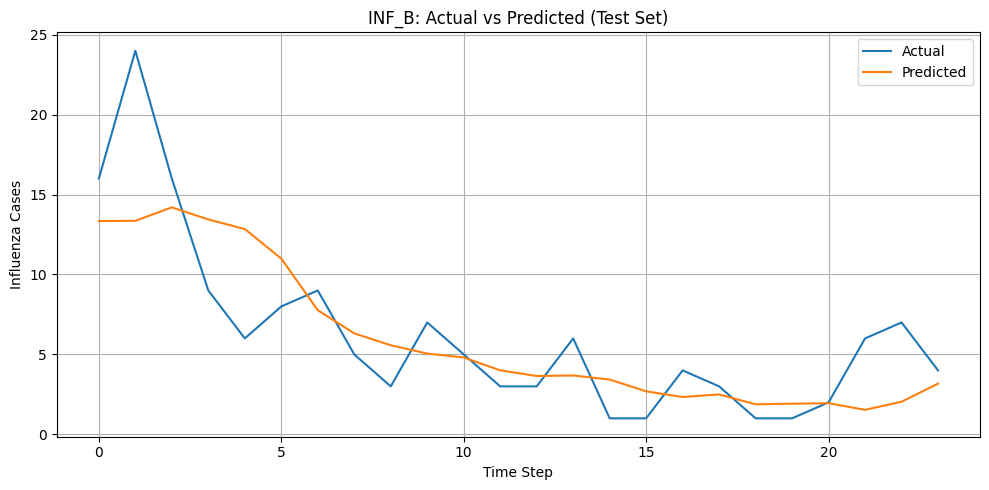

In [20]:
# Plot for INF_A
plot_actual_vs_predicted(true_A, pred_A, 'INF_A: Actual vs Predicted (Test Set)')

# Plot for INF_B
plot_actual_vs_predicted(true_B, pred_B, 'INF_B: Actual vs Predicted (Test Set)')

34/34 [==============================] - 0s 636us/step


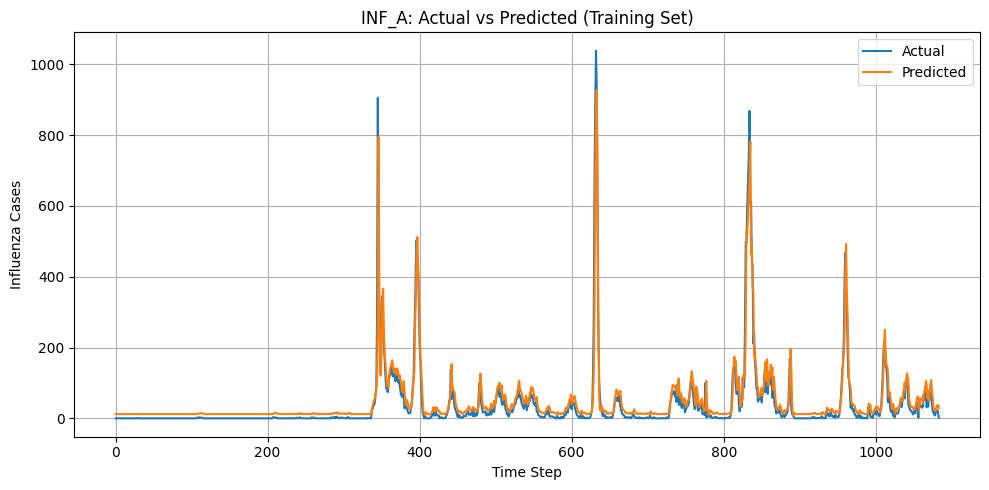

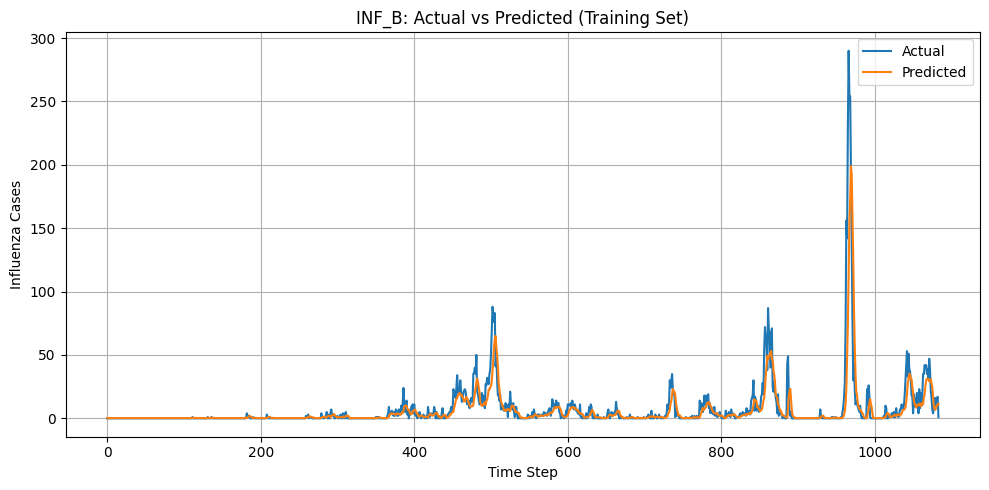

In [21]:
# Predict on training data
train_pred_A = scalers['INF_A'].inverse_transform(model_A.predict(X_train_A))
train_true_A = scalers['INF_A'].inverse_transform(y_train_A)

train_pred_B = scalers['INF_B'].inverse_transform(model_B.predict(X_train_B))
train_true_B = scalers['INF_B'].inverse_transform(y_train_B)

# Plotting function (reused from earlier)
def plot_actual_vs_predicted(true_values, predicted_values, title):
    plt.figure(figsize=(10, 5))
    plt.plot(true_values, label='Actual')
    plt.plot(predicted_values, label='Predicted')
    plt.title(title)
    plt.xlabel('Time Step')
    plt.ylabel('Influenza Cases')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for INF_A
plot_actual_vs_predicted(train_true_A, train_pred_A, 'INF_A: Actual vs Predicted (Training Set)')

# Plot for INF_B
plot_actual_vs_predicted(train_true_B, train_pred_B, 'INF_B: Actual vs Predicted (Training Set)')


### Plots with dates

34/34 [==============================] - 0s 762us/step


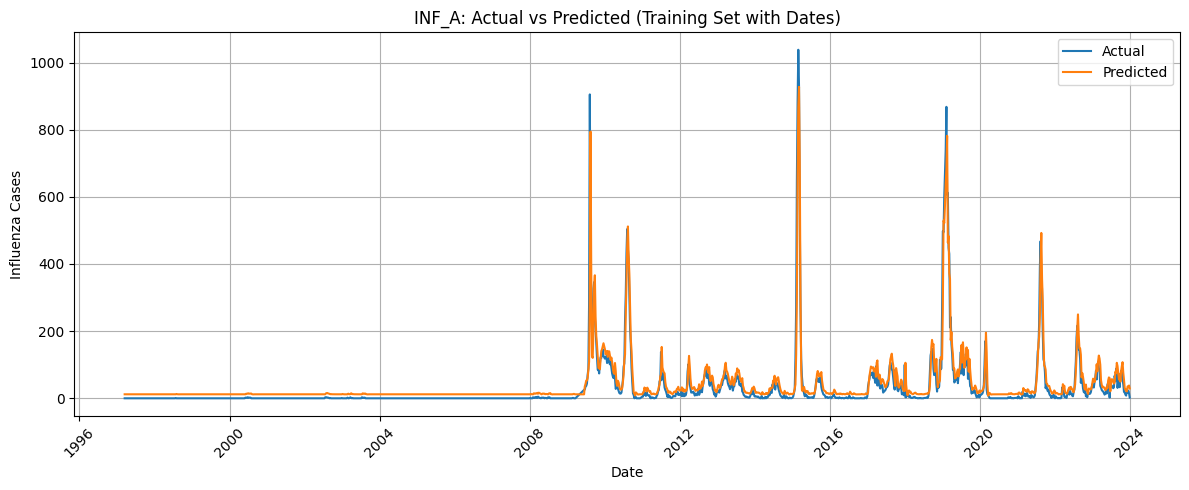

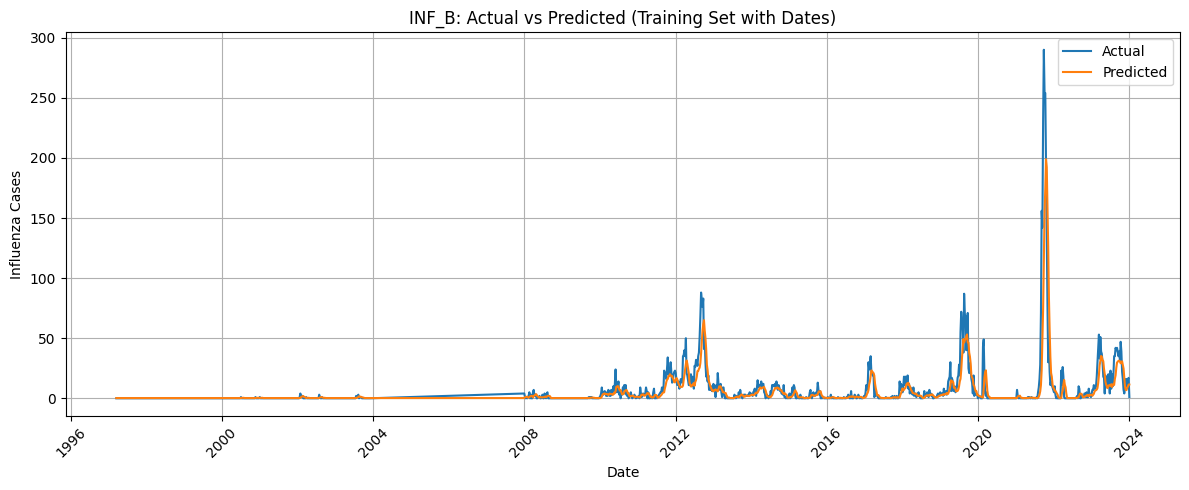

In [22]:
# Extract aligned dates from training index (skip first `window_size` entries)
train_dates = train_data.index[window_size:]

# Predict on training sequences
train_pred_A = scalers['INF_A'].inverse_transform(model_A.predict(X_train_A))
train_true_A = scalers['INF_A'].inverse_transform(y_train_A)

train_pred_B = scalers['INF_B'].inverse_transform(model_B.predict(X_train_B))
train_true_B = scalers['INF_B'].inverse_transform(y_train_B)

# Plotting with date index
def plot_with_dates(dates, true_values, predicted_values, title):
    plt.figure(figsize=(12, 5))
    plt.plot(dates, true_values, label='Actual')
    plt.plot(dates, predicted_values, label='Predicted')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Influenza Cases')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# INF_A plot
plot_with_dates(train_dates, train_true_A, train_pred_A, 'INF_A: Actual vs Predicted (Training Set with Dates)')

# INF_B plot
plot_with_dates(train_dates, train_true_B, train_pred_B, 'INF_B: Actual vs Predicted (Training Set with Dates)')


1/1 [==============================] - 0s 15ms/step


ValueError: x and y must have same first dimension, but have shapes (1084,) and (24, 1)

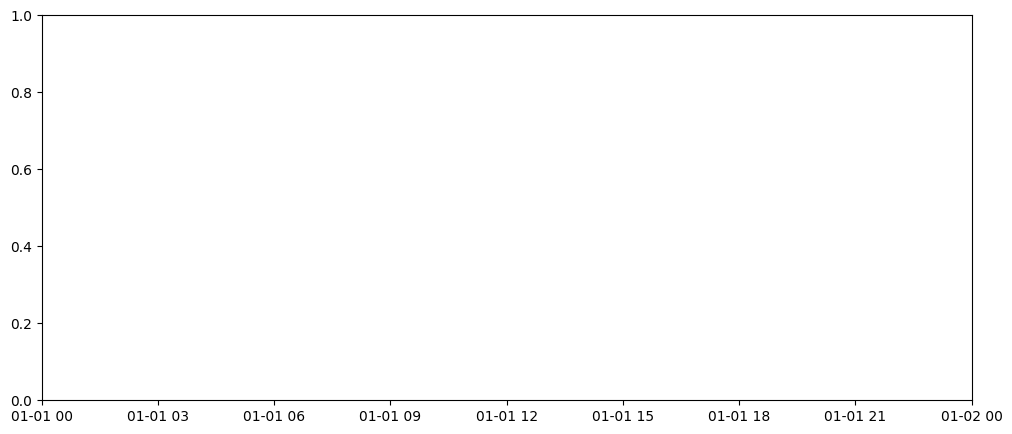

In [23]:
# Extract aligned dates from training index (skip first `window_size` entries)
test_dates = test_data.index[window_size:]

# Predict on training sequences
train_pred_A = scalers['INF_A'].inverse_transform(model_A.predict(X_test_A))
train_true_A = scalers['INF_A'].inverse_transform(y_test_A)

train_pred_B = scalers['INF_B'].inverse_transform(model_B.predict(X_test_B))
train_true_B = scalers['INF_B'].inverse_transform(y_test_B)

# Plotting with date index
def plot_with_dates(dates, true_values, predicted_values, title):
    plt.figure(figsize=(12, 5))
    plt.plot(dates, true_values, label='Actual')
    plt.plot(dates, predicted_values, label='Predicted')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Influenza Cases')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# INF_A plot
plot_with_dates(train_dates, train_true_A, train_pred_A, 'INF_A: Actual vs Predicted (Training Set with Dates)')

# INF_B plot
plot_with_dates(train_dates, train_true_B, train_pred_B, 'INF_B: Actual vs Predicted (Training Set with Dates)')
